In [12]:
import hopsworks
import pandas as pd
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194714
Connected. Call `.close()` to terminate connection gracefully.


#### Get or Create a new feature view

In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
flight_fg = fs.get_feature_group(name="flight_data_v2_class", version=1)
query = flight_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="flight_data_v2_class",
                                  version=1,
                                  description="Read from Flight Delay dataset",
                                  labels=["dep_delay_new"],
                                  query=query)

#### Create a new train test split

In [4]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (16.90s) 


#### Read from existing train test split

In [ ]:
#flight_fg = fs.get_feature_group(name="flight_data", version=1)
#query = flight_fg.select_all()
feature_view = fs.get_feature_view(name="flight_data_v2_class",version=1)
# get a training dataset with train and test splits
X_train, X_test, y_train, y_test = feature_view.get_train_test_split(training_dataset_version=1)

In [5]:
X_train

,year,month,day_of_month,day_of_week,origin_airport_id,origin_wac,dest_airport_id,dest_wac,crs_dep_time,crs_arr_time,hourlydewpointtemperature,hourlydrybulbtemperature,hourlyprecipitation,hourlyrelativehumidity,hourlystationpressure,hourlyvisibility,hourlywinddirection,hourlywindgustspeed,hourlywindspeed
1,2021,3,20,6,10397,34,11697,33,925,1120,-6.7,8.3,0.0,34.0,992.89,16.09,70,13.0,10.0
2,2021,8,31,2,12264,38,14771,91,715,950,21.1,23.9,0.0,84.0,1000.00,16.00,0,0.0,0.0
5,2021,7,7,3,12892,91,11057,36,2359,758,15.0,18.3,0.0,81.0,998.31,16.09,330,0.0,2.0
7,2021,5,31,1,12266,74,14771,91,712,923,20.6,25.0,0.0,77.0,1016.26,16.09,100,0.0,3.0
8,2022,2,8,2,12889,85,12892,91,1017,1136,-8.9,15.6,0.0,18.0,949.54,16.09,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662950,2022,5,28,6,14771,91,12889,85,2045,2219,12.2,15.0,0.0,83.0,1014.22,16.09,260,0.0,8.0
1662952,2021,6,30,3,11057,36,13204,33,1805,1945,20.6,30.0,0.0,57.0,991.53,16.09,220,0.0,4.0
1662953,2021,12,31,5,13204,33,13930,41,800,1000,20.0,20.6,0.0,96.0,1016.59,3.22,0,0.0,0.0
1662954,2021,9,29,3,11618,21,12266,74,1530,1820,5.0,21.7,0.0,34.0,1013.88,16.09,310,10.0,7.0


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1330364 entries, 1 to 1662955
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   year                       1330364 non-null  int64  
 1   month                      1330364 non-null  int64  
 2   day_of_month               1330364 non-null  int64  
 3   day_of_week                1330364 non-null  int64  
 4   origin_airport_id          1330364 non-null  int64  
 5   origin_wac                 1330364 non-null  int64  
 6   dest_airport_id            1330364 non-null  int64  
 7   dest_wac                   1330364 non-null  int64  
 8   crs_dep_time               1330364 non-null  int64  
 9   crs_arr_time               1330364 non-null  int64  
 10  hourlydewpointtemperature  1330364 non-null  float64
 11  hourlydrybulbtemperature   1330364 non-null  float64
 12  hourlyprecipitation        1330364 non-null  float64
 13  hourlyrelativehum

In [7]:
y_train

,dep_delay_new
1,0
2,0
5,0
7,0
8,0
...,...
1662950,0
1662952,3
1662953,0
1662954,0


In [8]:
y_train.values.ravel()

array([0, 0, 0, ..., 0, 0, 0])

#### Random Forest classifier Model

In [9]:
# Initialize the Random Forest classifier
# Initialize the Random Forest classifier
model_RF = RandomForestClassifier(n_estimators=100,max_depth=10, random_state=1)  # Set appropriate parameters

# Train the classifier
model_RF.fit(X_train, y_train)  # Use X_train for features and y_train for labels

# Predict labels for the test set
y_pred = model_RF.predict(X_test)


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred,output_dict=True)
results = confusion_matrix(y_test, y_pred)

RMSE: 1.0318696696548948
MAE: 0.43032003175061334
R-squared: -0.20241427387176603
Mean Squared Error (MSE): 1.0647550151537017


Accuracy: 0.79


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.89    263807
           1       0.00      0.00      0.00     24699
           2       0.00      0.00      0.00     12915
           3       0.66      0.01      0.03     31171

    accuracy                           0.79    332592
   macro avg       0.36      0.25      0.23    332592
weighted avg       0.69      0.79      0.70    332592



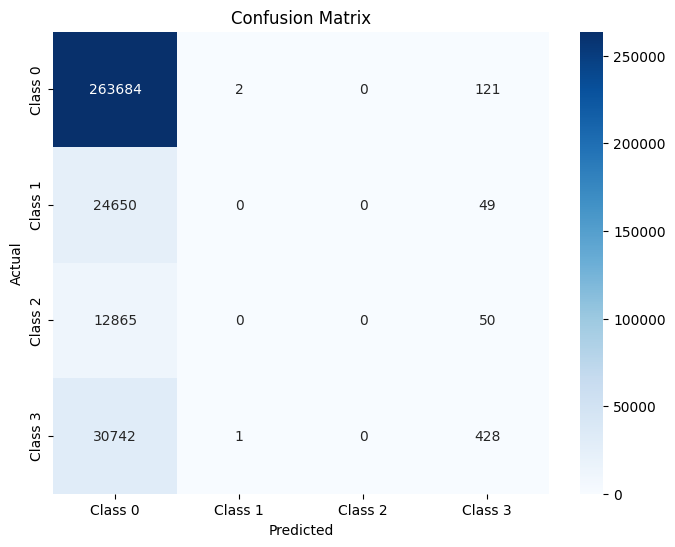

In [13]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred,output_dict=True)
results = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"Class {i}" for i in range(4)], 
            yticklabels=[f"Class {i}" for i in range(4)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Multinomial Logistic Regression

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.79


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    263807
           1       0.00      0.00      0.00     24699
           2       0.00      0.00      0.00     12915
           3       0.00      0.00      0.00     31171

    accuracy                           0.79    332592
   macro avg       0.20      0.25      0.22    332592
weighted avg       0.63      0.79      0.70    332592



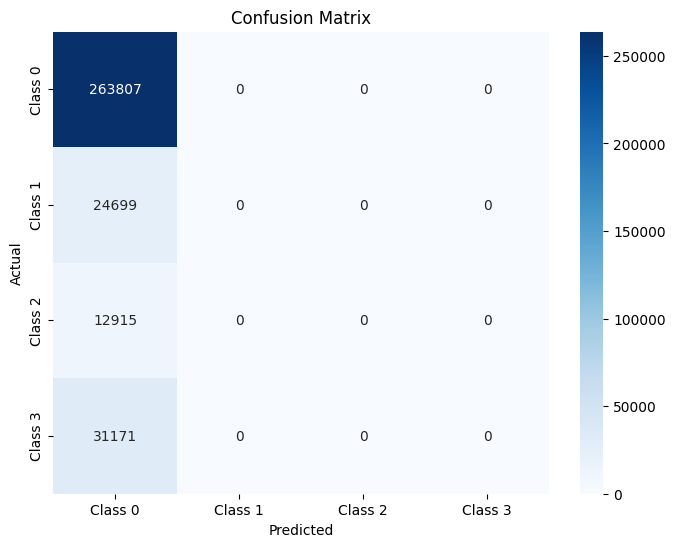

In [15]:
# Initialize the Linear Regression model
model_logistic = LogisticRegression(max_iter=1000, random_state=1)  # Set appropriate parameters

# Fit the model on the training data
model_logistic.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_logistic.predict(X_test)

# Calculate the Mean Squared Error (MSE) on test set
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred,output_dict=True)
results = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"Class {i}" for i in range(4)], 
            yticklabels=[f"Class {i}" for i in range(4)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Neural Network

In [17]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [18]:
# Normalize features (optional but often recommended for neural networks)
# outputs np arrays
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tensor)
X_test_scaled = scaler.transform(X_test_tensor)

In [19]:
# Convert the scaled NumPy arrays back to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [20]:
# Convert to PyTorch Dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [23]:
# Initialize the model
input_size = X_train_tensor.shape[1]
model = NeuralNetwork(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Train the model
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    #convert to rmse
    train_loss = running_loss / len(train_loader)
    train_rmse = torch.sqrt(torch.tensor(train_loss))
    
    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
        val_loss /= len(val_loader)

    val_rmse = torch.sqrt(torch.tensor(val_loss))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss MSE: {train_loss}, Train Loss RMSE: {train_rmse}, Val Loss MSE: {val_loss}, Val RMSE: {val_rmse}")

Epoch 1/25, Train Loss MSE: 2407.4271894304384, Train Loss RMSE: 49.0655403137207, Val Loss MSE: 2323.6752567610556, Val RMSE: 48.20451736450195
Epoch 2/25, Train Loss MSE: 2389.8179003234295, Train Loss RMSE: 48.885765075683594, Val Loss MSE: 2314.1992039749293, Val RMSE: 48.10612487792969
Epoch 3/25, Train Loss MSE: 2382.5500641100366, Train Loss RMSE: 48.81137466430664, Val Loss MSE: 2311.9186152615453, Val RMSE: 48.08241653442383
Epoch 4/25, Train Loss MSE: 2379.301379003904, Train Loss RMSE: 48.77808380126953, Val Loss MSE: 2303.4545022958237, Val RMSE: 47.99431610107422
Epoch 5/25, Train Loss MSE: 2374.979973282908, Train Loss RMSE: 48.733768463134766, Val Loss MSE: 2303.423386651414, Val RMSE: 47.99399185180664
Epoch 6/25, Train Loss MSE: 2372.982733050942, Train Loss RMSE: 48.71327209472656, Val Loss MSE: 2304.653378919521, Val RMSE: 48.006805419921875
Epoch 7/25, Train Loss MSE: 2371.576577881963, Train Loss RMSE: 48.69883728027344, Val Loss MSE: 2302.475309358369, Val RMSE: 4

#### Save to Hopsworks Model Registry 

In [24]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="flight delay model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/flight_delay_model.pkl")
#fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
#input_schema = Schema(X_train_tensor)
#output_schema = Schema(y_train_tensor)
#model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
fligt_delay_model = mr.python.create_model(
    name="flight_delay_model", 
    #metrics={"accuracy" : metrics['accuracy']},
    metrics={"val MSE" : 2252},
    #model_schema=model_schema,
    description="Flight Delay Predictor no schema"
)

# Upload the model to the model registry, including all files in 'model_dir'
fligt_delay_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 46789/46789 elapsed<00:01 remaining<00:001,  3.23it/s]
Model export complete: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/194714/models/flight_delay_model/1


Model(name: 'flight_delay_model', version: 1)

### Example showing how to load the NN model from Model Registry and how to use it for inference

Class definition needed due to how python loads saved pytorch models. The class definition is used to load the pickle model. If the pytorch model was saved as a state dict it could also be loaded using state_dict without defining class definition

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

mr = project.get_model_registry()
model = mr.get_model("flight_delay_model", version=1)
model_dir = model.download()
model = joblib.load(model_dir + "/flight_delay_model.pkl")


Connected. Call `.close()` to terminate connection gracefully.


In [37]:
#Data sample used for inference
i_test=0
a=X_train.iloc[i_test]
a=torch.tensor(a, dtype=torch.float32)

#Fit scaler to how it was fitted during training
scaler = StandardScaler()
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_train_scaled = scaler.fit_transform(X_train_tensor)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)

#transform data sample
a=scaler.transform(a.reshape(1, -1))
print(a)
print(X_train_tensor[i_test])

# transform np array to torch tensor
a_tensor=torch.tensor(a, dtype=torch.float32)

print(a_tensor)
print(model(a_tensor))
print(y_train.iloc[i_test])

[[-1.05282281  1.24782137  0.02323961 -0.99690901  1.18383447 -1.1339801
  -0.67183469 -0.77138126 -1.05325297 -0.80630688 -1.06317687 -1.3894594
  -0.09987404  0.10331179  0.70543781  0.33138419  0.66613952 -0.35530529
  -0.04343485]]
tensor([-1.0528,  1.2478,  0.0232, -0.9969,  1.1838, -1.1340, -0.6718, -0.7714,
        -1.0533, -0.8063, -1.0632, -1.3895, -0.0999,  0.1033,  0.7054,  0.3314,
         0.6661, -0.3553, -0.0434])
tensor([[-1.0528,  1.2478,  0.0232, -0.9969,  1.1838, -1.1340, -0.6718, -0.7714,
         -1.0533, -0.8063, -1.0632, -1.3895, -0.0999,  0.1033,  0.7054,  0.3314,
          0.6661, -0.3553, -0.0434]])
tensor([[7.3723]], grad_fn=<AddmmBackward0>)
dep_delay_new    0.0
Name: 1, dtype: float64
